### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sys import getsizeof
from time import time
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image

### Params

In [2]:
resized = 512
num_clusters = 84
top_n_results = 10

CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


### Data loading

In [3]:
# Subclassing image folder to override getitem for only img and path
class ImageFolderwoTargets(datasets.ImageFolder):    
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, path

In [4]:
# transformations used: resize to 512x512, normalised to torchvision values: https://pytorch.org/vision/0.12/models.html 
mods = transforms.Compose([transforms.Resize((resized,resized)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                          ])

# dataset-full; dataset-100 for 100 imgs per class; dataset-500 for 500 imgs per class
dataset = ImageFolderwoTargets('dataset-full/train', mods)

### Pre-trained model

In [5]:
model = models.resnet50(pretrained=True)
# print(model)

# extract no. of features req. bef. final classifier layer, then remove the layer
final_num_feats = model.fc.in_features
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# not intending to fine-tune pre-trained model weights
for param in model.parameters():
    param.require_grad = False

model.to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Using KMeans Clustering as a rudimentary Vector Quantisation

In [11]:
# Get all paths and feature vectors of the imgs in the dataset
full_feature_set = []
full_path_set = []

start_time = time()
with torch.no_grad():
    for img, path in dataset:
        img = img.reshape(1,*img.shape).to(device)
#         print(img.shape)
        full_feature_set.append(model(img).detach().squeeze().to('cpu'))
        full_path_set.append(path)

print(f'Time taken to build: {(time()-start_time)/3600} hrs')

with open('full_feature_set.pickle','wb') as f:
    pickle.dump(full_feature_set, f)
    
with open('full_path_set.pickle','wb') as f:
    pickle.dump(full_path_set, f)

Time taken to build: 1.1723097248209848 hrs


In [42]:
# Cluster dataset imgs,
kmeans = KMeans(n_clusters=num_clusters)
start_time = time()
kmeans.fit(torch.stack(full_feature_set))
print(f'Time taken to fit clustering: {time()-start_time} seconds')
print('\nWriting kmeans model to disk...')
with open('kmeans-84.pickle','wb') as f:
    pickle.dump(kmeans, f)
print('Done.')

start_time = time()
feature_book = {}  # {cluster: [(feature_vec, path), ...], ...}
for i in range(len(kmeans.labels_)):
    if kmeans.labels_[i] in feature_book.keys():
        feature_book[kmeans.labels_[i]].append((full_feature_set[i], full_path_set[i]))
    else:
        feature_book[kmeans.labels_[i]] = [(full_feature_set[i], full_path_set[i])]
print(f'\nTime taken to build feature_book: {time()-start_time} seconds')

Time taken to fit clustering: 585.3832714557648 seconds

Writing kmeans model to disk...
Done.

Time taken to build feature_book: 0.24429965019226074 seconds


In [43]:
# then store each cluster's pts in a nearest-neighoubours 'graph' 
cluster_book = {}  # {cluster: (knn_model, [paths]), ...}

start_time = time()
for cluster in feature_book.keys():
    cluster_feature_list = [feature for feature, _ in feature_book[cluster]]
    cluster_path_list = [path for _, path in feature_book[cluster]]
    knn = NearestNeighbors(n_neighbors=top_n_results)
    knn.fit(torch.stack(cluster_feature_list))
    cluster_book[cluster] = (knn, cluster_path_list)

print(f'Time taken to build cluster_book index: {time()-start_time} seconds')
# print(f'Size of index: {getsizeof(cluster_book)/1000} kilobytes')
print('\nWriting index to disk...')
with open('cluster_book-84.pickle','wb') as f:
    pickle.dump(cluster_book, f)
print('Done.')

Time taken to build cluster_book index: 30.479230403900146

Writing index to disk...
Done.


### Querying

In [6]:
# if loading from disk
with open('cluster_book-84.pickle', 'rb') as f:
    cluster_book = pickle.load(f)
with open('kmeans-84.pickle', 'rb') as f:
    kmeans = pickle.load(f)

In [15]:
# querying single img
query_file = 'dettol.jpg'
query_img = Image.open(query_file)
plt.imshow(plt.imread(query_file))
plt.title('Query Image')
query_tensor = mods(query_img)
query_tensor = query_tensor.reshape(1, *query_tensor.shape).to(device)

with torch.no_grad():
    query_feats = model(query_tensor).detach().squeeze().to('cpu')

In [16]:
# Searching for k-nearest neighbours from query_img within this cluster
cluster_indices = kmeans.predict(query_feats.reshape(1,-1))
cluster_knn_model, cluster_path_list = cluster_book[cluster_indices[0]]

dists, indices = cluster_knn_model.kneighbors(query_feats.reshape(1,-1), return_distance=True)
print(dists)  # kneighbours already returns in ascending order of (in this case) euclid dist

[[3.26650806 4.26251633 4.27864617 4.7595936  6.64505524 6.67958272
  6.72674849 6.87590808 6.92017931 7.35651912]]


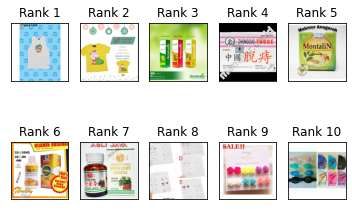

In [17]:
# Displaying results
if top_n_results%2 == 0:
    rows = 2
    cols = top_n_results//2
elif top_n_results%3 == 0:
    rows = 3
    cols = top_n_results//3
else:
    rows = 1
    cols = top_n_results

fig, chungus = plt.subplots(rows, cols)
axes = [ax for axes in chungus for ax in axes]
for i in range(len(indices[0])):
    axes[i].imshow(plt.imread(cluster_path_list[i]))
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Rank {i+1}')

### All together as one cell

Time taken to retrieve: 0.2747988700866699 seconds


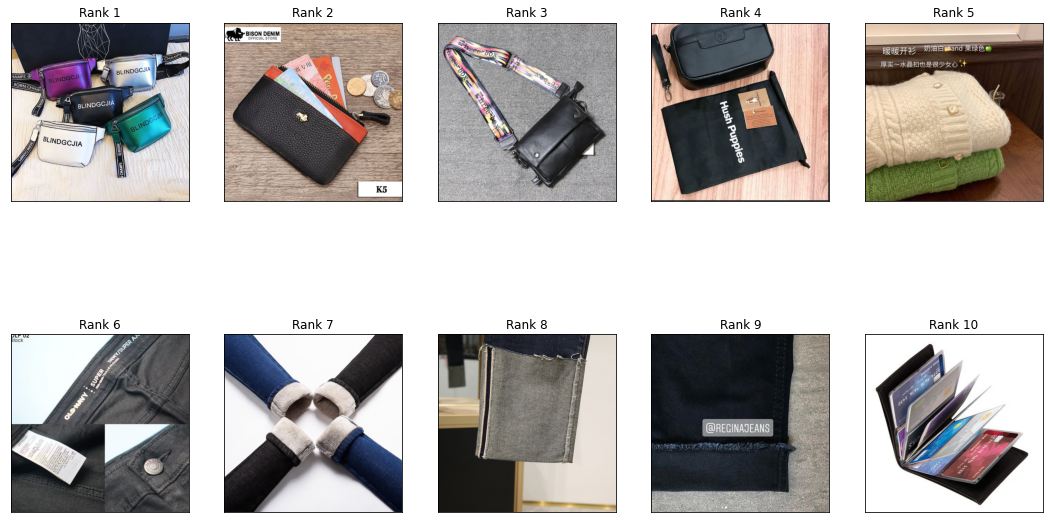

In [19]:
with open('cluster_book-42.pickle', 'rb') as f:
    cluster_book = pickle.load(f)
with open('kmeans-42.pickle', 'rb') as f:
    kmeans = pickle.load(f)
    
start_time = time()
query_img = Image.open('phone.jpg')
query_tensor = mods(query_img)
query_tensor = query_tensor.reshape(1, *query_tensor.shape).to(device)

with torch.no_grad():
    query_feats = model(query_tensor).detach().squeeze().to('cpu')
    
cluster_indices = kmeans.predict(query_feats.reshape(1,-1))
cluster_knn_model, cluster_path_list = cluster_book[cluster_indices[0]]

dists, indices = cluster_knn_model.kneighbors(query_feats.reshape(1,-1), return_distance=True)

if top_n_results%2 == 0:
    rows = 2
    cols = top_n_results//2
elif top_n_results%3 == 0:
    rows = 3
    cols = top_n_results//3
else:
    rows = 1
    cols = top_n_results

fig, chungus = plt.subplots(rows, cols)
fig.set_size_inches(18.5, 10.5)
axes = [ax for axes in chungus for ax in axes]
for i in range(len(indices[0])):
    axes[i].imshow(plt.imread(cluster_path_list[i]))
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Rank {i+1}')

print(f'Time taken to retrieve: {time()-start_time} seconds')